## Research Objective

**Hypotheses**: 

The hypothesis is that low-income countries might be less dependent on flights for tourism, possibly due to regional tourism or overland travel methods (like buses, trains, or cars)

**Main question**: 

"From 2010 to 2022, how did variations in flight volume, GDP growth, and tourism revenue interrelate, and can these trends reveal economic resilience patterns or unexpected behaviors among countries categorized by income class?"
Eventually, with Kmeans, a clustering is done to check of there is indeed correlation

**Sub questions**:
- 1: How are income classes currently determined, and which countries serve as typical examples for each class?

- 2: Does holistic clustering of countries based on flight volume, GDP growth, and tourism revenue reveal tangible differences between the predefined income classes?

- 3: Among the variables of flight volume, GDP growth, and tourism revenue, which has the most significant influence on a country's classification within an income class

- 4: Are the numbers of flights a decent consideration to determine the income class of a country?

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import scipy.stats as stats
from sklearn.cluster import KMeans


In [78]:
traffic = pd.read_csv('Datasets/air_passengers_from2000.csv')
tourism = pd.read_csv('Datasets/tourism_from2000.csv')
gdp = pd.read_csv('Datasets/gdp_from2000.csv')

In [79]:
def quarter_to_month(quarter):
    year, qtr = quarter.split('-')
    if qtr == 'Q1':
        return [f'{year}-01', f'{year}-02', f'{year}-03']
    elif qtr == 'Q2':
        return [f'{year}-04', f'{year}-05', f'{year}-06']
    elif qtr == 'Q3':
        return [f'{year}-07', f'{year}-08', f'{year}-09']
    else: # 'Q4'
        return [f'{year}-10', f'{year}-11', f'{year}-12']

mask = gdp['TIME_PERIOD'].str.match(r'\d{4}-Q[1-4]$')
gdp.loc[mask, 'TIME_PERIOD'] = gdp.loc[mask, 'TIME_PERIOD'].apply(quarter_to_month)
gdp = gdp.explode('TIME_PERIOD')

In [80]:
gdp

,DATAFLOW,LAST UPDATE,freq,unit,s_adj,na_item,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
0,ESTAT:NAMQ_10_PC(1.0),12/10/23 23:00:00,Q,CLV10_EUR_HAB,NSA,B1GQ,AT,2000-01,7560.0,NaN
0,ESTAT:NAMQ_10_PC(1.0),12/10/23 23:00:00,Q,CLV10_EUR_HAB,NSA,B1GQ,AT,2000-02,7560.0,NaN
0,ESTAT:NAMQ_10_PC(1.0),12/10/23 23:00:00,Q,CLV10_EUR_HAB,NSA,B1GQ,AT,2000-03,7560.0,NaN
1,ESTAT:NAMQ_10_PC(1.0),12/10/23 23:00:00,Q,CLV10_EUR_HAB,NSA,B1GQ,AT,2000-04,7900.0,NaN
1,ESTAT:NAMQ_10_PC(1.0),12/10/23 23:00:00,Q,CLV10_EUR_HAB,NSA,B1GQ,AT,2000-05,7900.0,NaN
...,...,...,...,...,...,...,...,...,...,...
86577,ESTAT:NAMQ_10_PC(1.0),12/10/23 23:00:00,Q,CP_NAC_HAB,NSA,P3_S13,UK,2020-05,1830.0,NaN
86577,ESTAT:NAMQ_10_PC(1.0),12/10/23 23:00:00,Q,CP_NAC_HAB,NSA,P3_S13,UK,2020-06,1830.0,NaN
86578,ESTAT:NAMQ_10_PC(1.0),12/10/23 23:00:00,Q,CP_NAC_HAB,NSA,P3_S13,UK,2020-07,1840.0,NaN
86578,ESTAT:NAMQ_10_PC(1.0),12/10/23 23:00:00,Q,CP_NAC_HAB,NSA,P3_S13,UK,2020-08,1840.0,NaN


In [81]:
# Make a database 
traffic = traffic.rename(columns={'OBS_VALUE': 'Traffic'})
tourism = tourism.rename(columns={'OBS_VALUE': 'Tourism'})
gdp = gdp.rename(columns={'OBS_VALUE': 'GDP'})


traffic_filtered = traffic[
    (traffic['tra_meas'] == 'PAS_BRD') &
    (traffic['TIME_PERIOD'] >= '2010-01') & 
    (traffic['TIME_PERIOD'] <= '2022-01')                   
]

tourism_filtered = tourism[
    (tourism['unit'] == 'NR') &
    (tourism['nace_r2'] == 'I551') &
    (tourism['c_resid'] == 'TOTAL') &
    (tourism['TIME_PERIOD'] >= '2010-01') &
    (tourism['TIME_PERIOD'] <= '2022-01')
]

gdp_filtered = gdp[
    (gdp['unit'] == 'CP_EUR_HAB') &
    (gdp['s_adj'] == 'NSA') &
    (gdp['na_item'] == 'B1GQ') &
    (gdp['TIME_PERIOD'] >= '2010-01') &
    (gdp['TIME_PERIOD'] <= '2022-01')
]

In [82]:
# Merge the dataset into 1 big dataset
countries = ["AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "EL", "ES", "FI", "FR", "HR", "HU", "IT", "LT", "LU", "LV", "MT", "NL", "PL", "PT", "RO", "SE", "SI", "SK"]

traffic_filtered = traffic_filtered[traffic_filtered['geo'].isin(countries)]
tourism_filtered = tourism_filtered[tourism_filtered['geo'].isin(countries)]
gdp_filtered = gdp_filtered[gdp_filtered['geo'].isin(countries)]


merged_data = pd.merge(traffic_filtered[['TIME_PERIOD', 'geo', 'Traffic']], 
                       gdp_filtered[['TIME_PERIOD', 'geo', 'GDP']], 
                       on=['TIME_PERIOD', 'geo'], 
                       how='outer')

merged_data = pd.merge(merged_data,
                       tourism_filtered[['TIME_PERIOD', 'geo', 'Tourism']], 
                       on=['TIME_PERIOD', 'geo'], 
                       how='outer')

In [83]:
# Check if there are Nan values
# nan_rows = merged_data[merged_data.isna().any(axis=1)]
# print(nan_rows)


In [84]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data[['Traffic','Tourism', 'GDP']])

In [85]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)
merged_data['Cluster'] = clusters

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


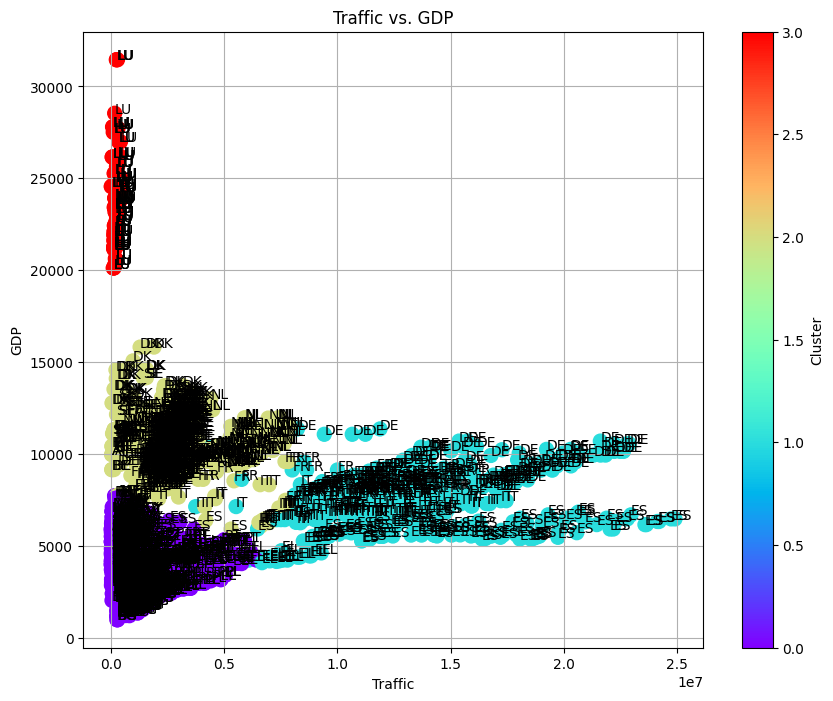

In [86]:
# # Scatter plot for Traffic vs. Tourism
# plt.figure(figsize=(10, 8))
# plt.scatter(merged_data['Traffic'], merged_data['Tourism'], c=merged_data['Cluster'], cmap='rainbow', s=100)
# for idx, row in merged_data.iterrows():
#     plt.text(row['Traffic'], row['Tourism'], row['geo'])
# plt.xlabel('Traffic')
# plt.ylabel('Tourism')
# plt.title('Traffic vs. Tourism')
# plt.colorbar().set_label('Cluster')
# plt.grid(True)
# plt.show()

# Scatter plot for Traffic vs. gdp
plt.figure(figsize=(10, 8))
plt.scatter(merged_data['Traffic'], merged_data['GDP'], c=merged_data['Cluster'], cmap='rainbow', s=100)
for idx, row in merged_data.iterrows():
    plt.text(row['Traffic'], row['GDP'], row['geo'])
plt.xlabel('Traffic')
plt.ylabel('GDP')
plt.title('Traffic vs. GDP')
plt.colorbar().set_label('Cluster')
plt.grid(True)
plt.show()

In [87]:
def mode_cluster(x):
    mode, _ = stats.mode(x)
    return mode[0]

country_clusters = merged_data.groupby('geo')['Cluster'].apply(mode_cluster).reset_index()
for cluster_num in range(k):
    print(f"Cluster {cluster_num}: {', '.join(country_clusters[country_clusters['Cluster'] == cluster_num]['geo'].tolist())}")


Cluster 0: BG, CY, CZ, EE, EL, HR, HU, LT, LV, MT, PL, PT, RO, SI, SK
Cluster 1: DE, ES, FR, IT
Cluster 2: AT, BE, DK, FI, NL, SE
Cluster 3: LU


/var/folders/t7/zv66s7112kz90jccz5_hq3480000gn/T/ipykernel_46238/3911225593.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(x)
